In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## MNISTデータセット

In [2]:
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


## データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

## 平滑化

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## 画像データの可視化

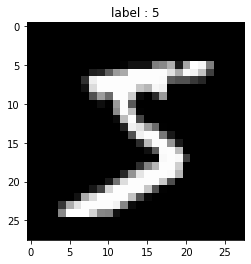

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

## 前処理

In [6]:
# 0から1のfloat型に変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [7]:
# one-hot表現 に変換
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [8]:
# 訓練データと検証データに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


## ニューラルネットワークスクラッチ

In [9]:
import sklearn.preprocessing as sp

class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    """
    def __init__(self, verbose, epoch, lr, sigma, activation):
        
        self.verbose = verbose
        self.lr = lr
        self.epoch = epoch
        self.activation = activation
        self.n_features = 784
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        self.batch_size = 20
        self.sigma = sigma
        
        self.W1 = None
        self.W2 = None
        self.W3 = None
        
        self.B1 = None
        self.B2 = None
        self.B3 = None
        
        self.browse = True
        
        self.loss = []
        self.loss_val = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        loss_buf = []
        loss_val_buf = []        
        
        # 重みの初期化
        self.W1 = self.init_weight(self.n_features, self.n_nodes1)        
        self.W2 = self.init_weight(self.n_nodes1, self.n_nodes2)                
        self.W3 = self.init_weight(self.n_nodes2, self.n_output)
        
        # バイアスの初期化
        self.B1 = np.zeros(self.n_nodes1)   
        self.B2 = np.zeros(self.n_nodes2)
        self.B3 = np.zeros(self.n_output)     
        
        
        for i in np.arange(self.epoch):
        
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size) # ミニバッチに分割

            for mini_X_train, mini_y_train in get_mini_batch:
                
                # フォワードプロパゲーション
                
                A1 = mini_X_train @ self.W1 + self.B1
                
                if self.activation=="sigmoid":
                    Z1 = self.sigmoid(A1)
                elif self.activation=="tanh":
                    Z1 = np.tanh(A1)
                
                A2 = Z1 @ self.W2 + self.B2
                
                if self.activation=="sigmoid":
                    Z2 = self.sigmoid(A2)
                elif self.activation=="tanh":
                    Z2 = np.tanh(A2)

                A3 = Z2 @ self.W3 + self.B3
                Z3 = self.softmax(A3)
                
                # 交差エントロピー誤差
                loss_buf.append(self.cross_entropy_error(Z3,  mini_y_train))
                
                if X_val is not None and y_val is not None:
                    A1_val = X_val @ self.W1 + self.B1
                    if self.activation=="sigmoid":
                        Z1_val = self.sigmoid(A1_val)
                    elif self.activation=="tanh":
                        Z1_val = np.tanh(A1_val)
                    A2_val = Z1_val @ self.W2 + self.B2
                    if self.activation=="sigmoid":
                        Z2_val = self.sigmoid(A2_val)
                    elif self.activation=="tanh":
                        Z2_val = np.tanh(A2_val)
                    A3_val = Z2_val @ self.W3 + self.B3
                    Z3_val = self.softmax(A3_val)
                    loss_val_buf.append(self.cross_entropy_error(Z3_val,  y_val))
                
                # バックプロパゲーション
                
                # 3層目
                dL_dA3 = Z3 - mini_y_train
                dL_dB3 = np.sum(dL_dA3, axis=0)
                dL_dW3 = Z2.T @ dL_dA3
                dL_dZ2 = dL_dA3 @ self.W3.T 
                
                # 2層目
                if self.activation=="sigmoid":
                    dL_dA2 = dL_dZ2 * (1. - self.sigmoid(A2))*self.sigmoid(A2)
                elif self.activation=="tanh":
                    dL_dA2 = dL_dZ2 * (1. - np.tanh(A2)**2)              
                    
                dL_dB2 = np.sum(dL_dA2, axis=0)
                dL_dW2 = Z1.T @ dL_dA2
                dL_dZ1 = dL_dA2 @ self.W2.T                
                
                # 1層目
                if self.activation=="sigmoid":
                    dL_dA1 = dL_dZ1 * (1. - self.sigmoid(A1))*self.sigmoid(A1)
                elif self.activation=="tanh":
                    dL_dA1 = dL_dZ1 * (1. - np.tanh(A1)**2)              
                    
                dL_dB1 = np.sum(dL_dA1, axis=0)
                dL_dW1 = mini_X_train.T @ dL_dA1
                
                
                
                self.B3 = self.B3 - self.lr * dL_dB3
                self.W3 = self.W3 - self.lr * dL_dW3
                
                self.B2 = self.B2 - self.lr * dL_dB2
                self.W2 = self.W2 - self.lr * dL_dW2       
                
                self.B1 = self.B1 - self.lr * dL_dB1
                self.W1 = self.W1 - self.lr * dL_dW1          
                
    
            # 交差エントロピー誤差
            self.loss.append(np.mean(loss_buf))
            self.loss_val.append(np.mean(loss_val_buf))
    
    
    def forward(self, X):
    
        self.A1 = X @ self.W1 + self.B1

        if self.activation=="sigmoid":
            self.Z1 = self.sigmoid(self.A1)
        elif self.activation=="tanh":
            self.Z1 = np.tanh(self.A1)

        self.A2 = self.Z1 @ self.W2 + self.B2

        if self.activation=="sigmoid":
            self.Z2 = self.sigmoid(self.A2)
        elif self.activation=="tanh":
            self.Z2 = np.tanh(self.A2)

        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)    
        
        return self.Z3
    
    
    def cross_entropy_error(self, y_pred,  y_true):
        delta = 1e-7
        return -np.sum(y_true * np.log(y_pred + delta)) / self.batch_size
    
    
    def init_weight(self, n_input_nodes, n_output_nodes):
        # 重みの初期化
        w = self.sigma * np.random.randn(n_input_nodes, n_output_nodes)
        return w
    
    
    def softmax(self, X):
        
        #X = X - np.max(X, axis=0).reshape(1,-1)
        y = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return y
    
    
    def sigmoid(self, X):
         return 1.0 / (1.0 + np.exp(-X))

    
    def predict(self, X):
        
        A1 = X @ self.W1 + self.B1
        if self.activation=="sigmoid":
            Z1 = self.sigmoid(A1)
        elif self.activation=="tanh":
            Z1 = np.tanh(A1)

        A2 = Z1 @ self.W2 + self.B2
        if self.activation=="sigmoid":
            Z2 = self.sigmoid(A2)
        elif self.activation=="tanh":
            Z2 = np.tanh(A2)

        A3 = Z2 @ self.W3 + self.B3
        Z3 = self.softmax(A3) 
        
        y_pred = np.argmax(Z3, axis=1)
        
        return y_pred 

## ミニバッチ処理

In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# 【問題1】重みの初期値を決めるコードの作成

ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。  
重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。  
以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

## 重みの初期化
```python 
def init_weight(self, n_input_nodes, n_output_nodes):
    # 重みの初期化
    w = self.sigma * np.random.randn(n_input_nodes, n_output_nodes)
    return w
```

# 【問題2】フォワードプロパゲーションの実装

三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。  
各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。  
  
batch_size = 20 # バッチサイズ  
n_features = 784 # 特徴量の数  
n_nodes1 = 400 # 1層目のノード数  
n_nodes2 = 200 # 2層目のノード数  
n_output = 10 # 出力のクラス数（3層目のノード数）  
  
#### 「1層目」  
  
$A_1 = X \cdot W_1 + B_1$  
$X$ : 特徴量ベクトル (batch_size, n_features)  
$W_1$ : 1層目の重み (n_features, n_nodes1)  
$B_1$ : 1層目のバイアス (n_nodes1,)  
$A_1$ : 出力 (batch_size, n_nodes1)  
#### 「1層目の活性化関数」
$Z_1 = f(A_1)$  
$f() $: 活性化関数  
$Z_1$ 出力 (batch_size, n_nodes1)  
#### 「2層目」
$A_2 = Z_1 \cdot W_2 + B_2$  
$W_2$ : 2層目の重み (n_nodes1, n_nodes2)  
$B_2$ : 2層目のバイアス (n_nodes2,)  
$A_2$ : 出力 (batch_size, n_nodes2)  
#### 「2層目の活性化関数」
$Z_2 = f(A_2)$  
$f()$ : 活性化関数  
$Z_2$ 出力 (batch_size, n_nodes2)  
#### 「3層目（出力層）」
$A_3 = Z_2 \cdot W_3 + B_3$  
$W_3$ : 3層目の重み (n_nodes2, n_output)  
$B_3$ : 3層目のバイアス (n_output,)  
$A_3$ : 出力 (batch_size, n_output)  
#### 「3層目の活性化関数」
$Z_3 = softmax(A_3)$  
$softmax()$ : ソフトマックス関数  
$Z_3$ 出力 (batch_size, n_output)  
$Z_3$ は各ラベル（0〜9）に対する確率の配列である。  

## シグモイド関数

```python  
def sigmoid(self, X):
     return 1.0 / (1.0 + np.exp(-X))
```

## ソフトマックス関数

```python  
def softmax(self, X):
    y = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
    return y
```

## フォワードプロパゲーション

```python
# フォワードプロパゲーション
A1 = mini_X_train @ self.W1 + self.B1

if self.activation=="sigmoid":
    Z1 = self.sigmoid(A1)
elif self.activation=="tanh":
    Z1 = np.tanh(A1)

A2 = Z1 @ self.W2 + self.B2

if self.activation=="sigmoid":
    Z2 = self.sigmoid(A2)
elif self.activation=="tanh":
    Z2 = np.tanh(A2)

A3 = Z2 @ self.W3 + self.B3
Z3 = self.softmax(A3)
```

# 【問題3】交差エントロピー誤差の実装

目的関数（損失関数）を作成します。  
多クラス分類の目的関数である交差エントロピー誤差 L は次の数式です。  
$L = - \frac{1}{n_b}\sum_{j}^{n_b}\sum_{k}^{n_c}y_{jk} log(z_{3\_jk})$  
$y_{ij}$ : $j$ 番目のサンプルの k 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）  
$z_{3_ij}$ : $j$ 番目のサンプルの k 番目のクラスの確率（スカラー）  
$n_{b}$ : バッチサイズ、batch_size  
$n_{c}$ : クラスの数、n_output（今回のMNISTでは10）  
サンプル1つあたりの誤差が求まります。  

## 交差エントロピー誤差

```python  
def cross_entropy_error(self, y_pred,  y_true):
    delta = 1e-7
    return -np.sum(y_true * np.log(y_pred + delta)) / self.batch_size
```

# 【問題4】バックプロパゲーションの実装

三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。  
数式を以下に示します。  
まず、i層目の重みとバイアスの更新式です。 W_i と B_i に対し、更新後の W_i^{\prime} と B_i^{\prime} は次の数式で求められます。  
$$
W_i^{\prime} = W_i - \alpha \frac{\partial L}{\partial W_i} \\
$$
$$
B_i^{\prime} = B_i - \alpha \frac{\partial L}{\partial B_i}
$$
$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）  
$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 L の勾配  
$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 L の勾配  
＊この勾配はミニバッチのサンプル数分の合計または平均を考えます。ここでは合計を計算します。  
この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。  
勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。  
#### 「3層目」  
$$
\frac{\partial L}{\partial A_3} = Z_{3} - Y\\
$$
$$
\frac{\partial L}{\partial B_3} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{3\_j}}\\
$$
$$
\frac{\partial L}{\partial W_3} = Z_{2}^{T}\cdot \frac{\partial L}{\partial A_3}\\
$$
$$
\frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_3} \cdot W_3^T
$$
$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 L の勾配 (batch_size, n_output)  
$\frac{\partial L}{\partial A_{3_j}}$ : $j$番目のサンプルの$A_3$ に関する損失 L の勾配 (n_nodes2,)  
$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 L の勾配 (n_output,)  
$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 L の勾配 (n_nodes2, n_output)  
$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 L の勾配 (batch_size, n_nodes2)  
$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_nodes2)  
$Y$ : 正解ラベル (batch_size, n_output)  
$Z_{2}$ : 2層目の活性化関数の出力 (batch_size, n_nodes2)  
$W_3$ : 3層目の重み (n_nodes2, n_output)  
#### 「2層目」  
$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \odot \{1-tanh^2(A_{2})\}\\
$$
$$
\frac{\partial L}{\partial B_2} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{2\_j}}\\
$$
$$
\frac{\partial L}{\partial W_2} = Z_{1}^T \cdot \frac{\partial L}{\partial A_2}\\
$$
$$
\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_2} \cdot W_2^T
$$
$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 L の勾配 (batch_size, n_nodes2)  
$\frac{\partial L}{\partial A_{2_j}}$ : $j$番目のサンプルのA_2 に関する損失 L の勾配 (n_nodes2,)  
$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 L の勾配 (n_output,)  
$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 L の勾配 (n_nodes1, n_nodes2)  
$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 L の勾配 (batch_size, n_nodes2)  
$A_2$ : 2層目の出力 (batch_size, n_nodes2)  
$Z_{1}$ : 1層目の活性化関数の出力 (batch_size, n_nodes1)  
$W_2$ : 2層目の重み (n_nodes1, n_nodes2)  
#### 「1層目」  
$$
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \odot \{1-tanh^2(A_{1})\}\\
$$
$$
\frac{\partial L}{\partial B_1} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{1\_j}}\\
$$
$$
\frac{\partial L}{\partial W_1} = X^T \cdot \frac{\partial L}{\partial A_1}\\
$$
$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 L の勾配 (batch_size, n_nodes1)  
$\frac{\partial L}{\partial A_{1_j}}$ : $j$番目のサンプルのA_1 に関する損失 L の勾配 (n_nodes1,)  
$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 L の勾配 (n_output,)  
$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 L の勾配 (n_features, n_nodes1)  
$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 L の勾配 (batch_size, n_nodes1)  
$A_1$ : 1層目の出力 (batch_size, n_nodes1)  
$X$ : 特徴量ベクトル (batch_size, n_features)  
$W_1$ : 1層目の重み (n_features, n_nodes1)  
#### 《補足》  
活性化関数にシグモイド関数を使用した場合は、次のようになります。  
$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \odot  \{1-sigmoid(A_{2})\}sigmoid(A_{2})
$$
$$
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \odot  \{1-sigmoid(A_{1})\}sigmoid(A_{1})
$$

## バックプロパゲーション

```python
# バックプロパゲーション

# 3層目
dL_dA3 = Z3 - mini_y_train
dL_dB3 = np.sum(dL_dA3, axis=0)
dL_dW3 = Z2.T @ dL_dA3
dL_dZ2 = dL_dA3 @ self.W3.T 

# 2層目
if self.activation=="sigmoid":
    dL_dA2 = dL_dZ2 * (1. - self.sigmoid(A2))*self.sigmoid(A2)
elif self.activation=="tanh":
    dL_dA2 = dL_dZ2 * (1. - np.tanh(A2)**2)              

dL_dB2 = np.sum(dL_dA2, axis=0)
dL_dW2 = Z1.T @ dL_dA2
dL_dZ1 = dL_dA2 @ self.W2.T                

# 1層目
if self.activation=="sigmoid":
    dL_dA1 = dL_dZ1 * (1. - self.sigmoid(A1))*self.sigmoid(A1)
elif self.activation=="tanh":
    dL_dA1 = dL_dZ1 * (1. - np.tanh(A1)**2)              

dL_dB1 = np.sum(dL_dA1, axis=0)
dL_dW1 = mini_X_train.T @ dL_dA1



self.B3 = self.B3 - self.lr * dL_dB3
self.W3 = self.W3 - self.lr * dL_dW3

self.B2 = self.B2 - self.lr * dL_dB2
self.W2 = self.W2 - self.lr * dL_dW2       

self.B1 = self.B1 - self.lr * dL_dB1
self.W1 = self.W1 - self.lr * dL_dW1
```

# 【問題5】推定

推定を行うメソッドを作成してください。  
フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

## 推定

```python
def predict(self, X):

    A1 = X @ self.W1 + self.B1
    if self.activation=="sigmoid":
        Z1 = self.sigmoid(A1)
    elif self.activation=="tanh":
        Z1 = np.tanh(A1)

    A2 = Z1 @ self.W2 + self.B2
    if self.activation=="sigmoid":
        Z2 = self.sigmoid(A2)
    elif self.activation=="tanh":
        Z2 = np.tanh(A2)

    A3 = Z2 @ self.W3 + self.B3
    Z3 = self.softmax(A3) 

    y_pred = np.argmax(Z3, axis=1)

    return y_pred 
```

# 【問題6】学習と推定

MNISTのデータを学習・推定し、Accuracyを計算してください。

In [11]:
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
print(X_train.shape)
print(y_train_one_hot.shape)

(48000, 784)
(48000, 10)


In [12]:
clf = ScratchSimpleNeuralNetrowkClassifier(False, 5, 0.01, 0.1, 'sigmoid')

In [13]:
clf.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [14]:
y_pred = clf.predict(X_val)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9608333333333333

# 【問題7】学習曲線のプロット

学習曲線をプロットしてください。  
ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

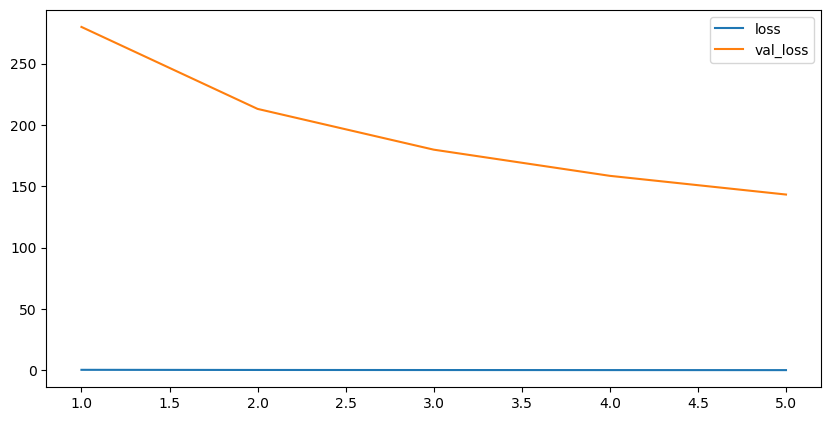

In [16]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(range(1,6), clf.loss, label='loss')
plt.plot(range(1,6), clf.loss_val, label='val_loss')
plt.legend()

# 【問題8】（アドバンス課題）誤分類の確認

誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。

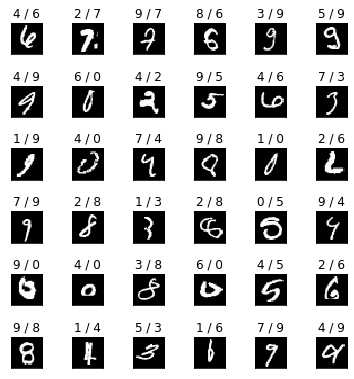

In [17]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか
true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

#### 考察
以下のようなものは判別が難しいと思われる  
・形が崩れたもの  
・文字が潰れているもの  
・数字がかすれているもの  